In [1]:
import torch
import torchvision
from torchvision import transforms,datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import random

Dataset

In [2]:
#官网下载
#train =datasets.MNIST("",train = True,download = True,transform = transforms.Compose([transforms.ToTensor()])) 
#test = datasets.MNIST("",train = True,download = True,transform = transforms.Compose([transforms.ToTensor()])) 
#本地导入
class DealDataset(torch.utils.data.Dataset):
    """
        读取数据、初始化数据
    """

    def __init__(self, folder, data_name, label_name, transform=None):
        # 其实也可以直接使用torch.load(),读取之后的结果为torch.Tensor形式
        (train_set, train_labels) = load_data(folder, data_name,label_name)  
        self.train_set = train_set
        self.train_labels = train_labels
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.train_set[index], int(self.train_labels[index])
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.train_set)


def load_data(data_folder, data_name, label_name):
    # rb表示的是读取二进制数据
    with gzip.open(os.path.join(data_folder, label_name), 'rb') as lbpath:  
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(os.path.join(data_folder, data_name), 'rb') as imgpath:
        x_train = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)
    return (x_train, y_train)


train = DealDataset(r'MNIST\raw', "train-images-idx3-ubyte.gz","train-labels-idx1-ubyte.gz", transform=transforms.ToTensor())
test = DealDataset(r'MNIST\raw', "t10k-images-idx3-ubyte.gz","t10k-labels-idx1-ubyte.gz", transform=transforms.ToTensor())

trainset=torch.utils.data.DataLoader(train,batch_size=10,shuffle=True)
testset=torch.utils.data.DataLoader(train,batch_size=10,shuffle=True)

#统计查看数据分布
#for data in trainset:
#   print(data)
#    break

#x,y=data[0][0],data[0][1]
#plt.imshow(x.view(28,28))
#plt.show()


#total=0
#counter_dict={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}

#for data in trainset:
#    xs,ys=data
#    for y in ys:
#        counter_dict[int(y)]+=1
#        total+=1
#print(counter_dict)
#for i in counter_dict:
#    print(f"{i}:{counter_dict[i]/total*100}%")        

Build Network

In [3]:


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #fully connected layer
        self.fc1=nn.Linear(28*28,64)
        self.fc2=nn.Linear(64,64)
        self.fc3=nn.Linear(64,64)
        self.fc4=nn.Linear(64,10)
            
    def forward(self,x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=self.fc4(x)
        
        return F.log_softmax(x,dim=1)

#net=Net()
#print(net)
        

#X=torch.rand([28,28])
#X=X.reshape(-1,28*28)

#output=net(X)

#output

Train Network

In [4]:
#构建实例
net=Net()
optimizer=torch.optim.Adam(net.parameters()) 

EPOCHS=3

for epoch in range(EPOCHS):
    for data in trainset:
        #data is a batch of featuresets and labels
        X,y=data
        net.zero_grad()
        output=net(X.view(-1,28*28))
        loss=F.nll_loss(output,y)
        loss.backward()
        optimizer.step()
    print('epoch {}: loss: {:.3f}'.format(epoch,loss.item()))

E:\software\Anaconda\lib\site-packages\torchvision\transforms\functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


epoch 0: loss: 0.705
epoch 1: loss: 0.003
epoch 2: loss: 0.028


Prediction Accuracy

In [5]:

correct=0
total=0
with torch.no_grad():
    for data in trainset:
        X,y=data
        output=net(X.view(-1,28*28))
        for idx , i in enumerate(output):
            if torch.argmax(i)==y[idx]:
                correct+=1
            total+=1
print("Accuracy:",round(correct/total,5))
        

Accuracy: 0.9799


Random Display Result

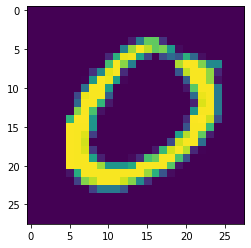

predict: 0
   real: 0


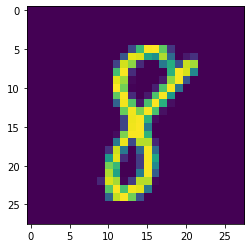

predict: 8
   real: 8


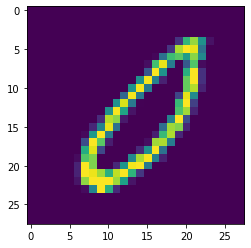

predict: 0
   real: 0


In [6]:
for i in range(3):
    num=random.randint(0,9)
    plt.imshow(X[num].view(28,28))
    plt.show()
    print('predict:',torch.argmax(net(X[num].view(-1,28*28))[0]).item())
    print('   real:',y[num].item())
